## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp
import DP_normal_mixture_opt_lib as dp_opt

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(3143)

# data parameters
num_obs = 1000 # number of observations 
x_dim = 2 # dimension of observations
k_true = 5 # true number of clusters

info_x = 0.3 * np.eye(x_dim) 

x, true_mu, true_z, true_pi = dp.draw_data(info_x, x_dim, k_true, num_obs)


# prior parameters
alpha = 2.0 # DP parameter
prior_mu = np.mean(x, axis = 0)
prior_info = 0.1 * np.eye(x_dim)

# variational truncation 
k_approx = 10 



observed mixture proportions: 
 [ 0.204  0.201  0.175  0.208  0.212]
true mixture proportions: 
 [ 0.2  0.2  0.2  0.2  0.2]


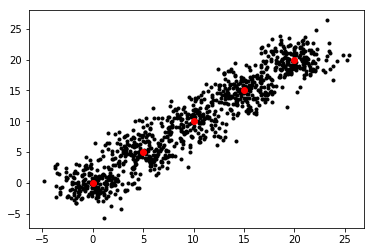

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

## Set up VB model

In [4]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [5]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))
prior_params.push_param(PosDefMatrixParam(name='prior_info', size=x_dim, val=prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

In [6]:
model = dp.DPNormalMixture(x, vb_params, prior_params)

## Initialize

In [7]:
## initialize VB params

true_init = False

if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    vb_params['global']['v_sticks'].alpha.set(true_tau)

    # vb_params['global']['mu'].set(true_mu)
    mu_size = vb_params['global']['mu'].free_size()
    vb_params['global']['mu'].set_free(np.random.random(mu_size))
    
    true_z_fudged = dp.soft_thresh(true_z, 1 - 10**(-8), 10**(-8))
    vb_params['local']['e_z'].set(true_z_fudged)
    # z_size = vb_params['local']['e_z'].free_size()
    # vb_params['local']['e_z'].set_free(np.random.random(z_size))
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_free_params = vb_params.get_free()
global_init_free_params = vb_params['global'].get_free()

## Run CAVI 

CAVI terminated successfully :)
iterations ran:  629


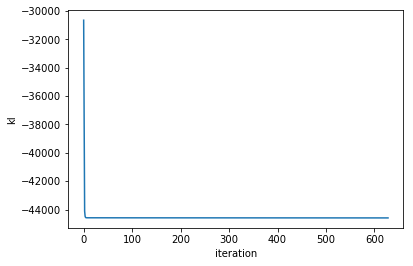

In [8]:
dp_opt.run_cavi(model, init_free_params, max_iter = 1000, tol = 1e-5, disp = False)
cavi_results = deepcopy(model)

### examine results of CAVI

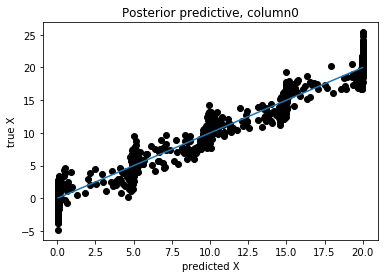

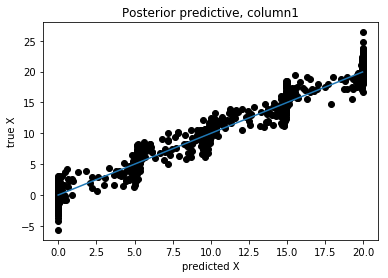

In [9]:
# plot posterior predictive
e_z = cavi_results.vb_params['local']['e_z'].get()
mu = cavi_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [10]:
# lets look at the estimated mixture proportions

tau = cavi_results.vb_params['global']['v_sticks'].alpha.get() 
post_stick_length = tau[:,0] / np.sum(tau, axis = 1) # mean posterior stick lengths

# compute mixture proportions using mean posterior stick lengths
post_pi = np.ones(k_approx)
stick_remain = np.ones(k_approx - 1)
for i in range(k_approx - 1):
    post_pi[i] = stick_remain[i - 1] * post_stick_length[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - post_stick_length[i])
post_pi[-1] = stick_remain[-1]
assert(np.abs(np.sum(post_pi) - 1.) < 10**(-10))

print('true_proportions', true_pi)
print('estimated proportions: ', post_pi, '\n')

heavy_clusters = post_pi > 1 / k_approx # clusters with significant weights 

print('true number of clusters: ', k_true)
print('number of "posterior clusters" (ie. no. clusters w/ siginifcant weights): ', np.sum(post_pi > 1 / k_approx))
print('recall variational truncation: ', k_approx)

true_proportions [ 0.2  0.2  0.2  0.2  0.2]
estimated proportions:  [ 0.00103921  0.19411039  0.02098208  0.03772041  0.00103388  0.20613063
  0.0010304   0.21145813  0.20225867  0.12423618] 

true number of clusters:  5
number of "posterior clusters" (ie. no. clusters w/ siginifcant weights):  5
recall variational truncation:  10


In [11]:
# lets look at posterior means
print('true means: ')
print(true_mu, '\n')

print('relevant posterior means (ie. posterior means for clusters with significant weights): ')
print(cavi_results.vb_params['global']['mu'].get()[heavy_clusters, :])

true means: 
[[ 0  0]
 [ 5  5]
 [10 10]
 [15 15]
 [20 20]] 

relevant posterior means (ie. posterior means for clusters with significant weights): 
[[  4.92424825e+00   5.10055368e+00]
 [  1.49641772e+01   1.49151451e+01]
 [  1.99869378e+01   1.99373862e+01]
 [  6.56068591e-02  -1.16303037e-02]
 [  9.85546129e+00   9.58329301e+00]]


## Newton Optimization

In [12]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [13]:
def minimize_kl(kl_obj, init_x, maxiter = 50, gtol = 1e-8, disp = True):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hess=kl_obj.fun_free_hessian,
        method='trust-ncg', options={'maxiter': maxiter, 'gtol': gtol, 'disp': disp})

    print('done')
    return vb_opt

newton_tr_init = cavi_results.vb_params['global'].get_free() # initialize with result from CAVI
newton_tr_opt = minimize_kl(kl_obj, newton_tr_init) # run Newton

         Current function value: -44593.213510
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 6
         Hessian evaluations: 6
done


In [14]:
model.vb_params['global'].set_free(newton_tr_opt.x)
model.set_optimal_z()

newton_results = deepcopy(model)

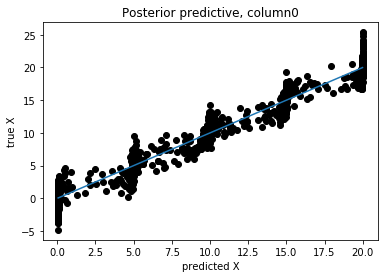

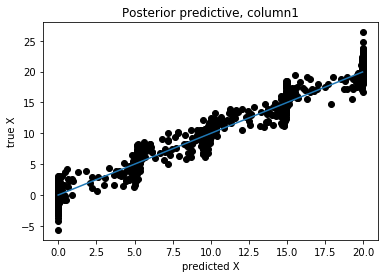

In [15]:
# plot posterior predictive
e_z = newton_results.vb_params['local']['e_z'].get()
mu = newton_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [16]:
# compare CAVI with Newton_tr
print(cavi_results.vb_params['global']['mu'].get())
print(newton_results.vb_params['global']['mu'].get())

print('l1 difference between means: ', \
      np.sum(np.abs(cavi_results.vb_params['global']['mu'].get() - newton_results.vb_params['global']['mu'].get())))

[[  1.01031033e+01   1.01278452e+01]
 [  4.92424825e+00   5.10055368e+00]
 [  7.30974527e+00   8.99240720e+00]
 [  1.09446142e+01   1.16327411e+01]
 [  1.01031044e+01   1.01278389e+01]
 [  1.49641772e+01   1.49151451e+01]
 [  1.01031051e+01   1.01278348e+01]
 [  1.99869378e+01   1.99373862e+01]
 [  6.56068591e-02  -1.16303037e-02]
 [  9.85546129e+00   9.58329301e+00]]
[[  1.01031295e+01   1.01279526e+01]
 [  4.92489570e+00   5.10059584e+00]
 [  7.31584369e+00   8.98171788e+00]
 [  1.09780920e+01   1.16852484e+01]
 [  1.01031304e+01   1.01279454e+01]
 [  1.49639807e+01   1.49148974e+01]
 [  1.01031310e+01   1.01279408e+01]
 [  1.99868923e+01   1.99373443e+01]
 [  6.56454250e-02  -1.15687330e-02]
 [  9.86836629e+00   9.60723030e+00]]
l1 difference between means:  0.14133444081


In [17]:
print('l1 difference (normalized) between all params: ', \
      np.mean(np.abs(cavi_results.vb_params.get_free() - newton_results.vb_params.get_free())))

l1 difference (normalized) between all params:  0.029331787085


In [25]:
# checking the optima

# check that the gradient is close to 0
kl_grad = kl_obj.fun_free_grad(newton_tr_opt.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)), '\n')

t0 = time.time()
kl_hessian = kl_obj.fun_free_hessian(newton_tr_opt.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute hessian (sec): ', hessian_time)
print('eigenvalues: \n', hessian_evals)
print('all positive: ', np.all(hessian_evals > 0))

L_inf norm of gradient:  1.24918348638e-07 

time to compute hessian (sec):  9.786979913711548
eigenvalues: 
 [  2.82873896e+02   2.64608357e+02   2.41709823e+02   1.32453188e+02
   6.29413937e+01   5.99170744e+01   5.83628090e+01   5.70819941e+01
   5.48366515e+01   5.18043443e+01   4.10751949e+01   3.51327347e+01
   2.91942406e+01   1.96164231e+01   4.80279473e+00   4.57623555e+00
   3.17248519e+00   2.39168097e+00   2.38872642e+00   2.39072798e+00
   1.66274624e+00   1.23484795e+00   1.31646606e+00   1.31372648e+00
   1.30915344e+00   6.13262046e-01   3.62169485e-01   3.26732871e-01
   1.42897462e-01   1.11310427e-01   2.70288780e-01   2.70456762e-01
   2.70537312e-01   2.50643253e-01   2.50464046e-01   2.50310677e-01
   2.50354953e-01   1.00951584e-01   1.00944363e-01   1.00939681e-01
   9.97939316e-02   9.97956863e-02   9.97968332e-02   2.00384302e+00
   1.99862914e+00   1.99891386e+00   1.99966588e+00   2.00000006e+00
   2.00000004e+00   1.99999998e+00   2.00000000e+00   2.000000

## Parametric sensitivity analysis
In particular, we are interested in the sensitivity of the posterior stick lengths to our choice of DP parameter $\alpha$

In [19]:
class DPNormalMixtureLRVB(object): 
    def __init__(self, model): 
        self.model = deepcopy(model)
        self.alpha = model.alpha
        
        self.get_moment_jac = autograd.jacobian(self.get_interesting_moments)        
        self.get_kl_hessian = autograd.hessian(self.kl, argnum = 0)
        
        self.get_kl_jac = autograd.jacobian(self.kl, argnum = 0)
        self.get_alpha_jac = autograd.jacobian(self.get_kl_jac, argnum = 1)
        
    def get_interesting_moments(self, global_free_params):
        self.model.vb_params['global'].set_free(global_free_params)  
        
        # returning average of the v_sticks
        return self.model.vb_params['global']['v_sticks'].e()[:,0]
    
    def kl(self, global_free_params, alpha):
        self.model.vb_params['global'].set_free(global_free_params)
        self.model.alpha = alpha
        
        return self.model.kl_optimize_z()
    
    def get_alpha_sensitivity(self, optimal_global_free_params): 
        moment_jac = self.get_moment_jac(optimal_global_free_params)
        kl_hessian = self.get_kl_hessian(optimal_global_free_params, self.alpha)
        
        sensitivity_operator = np.linalg.solve(kl_hessian, moment_jac.T)
                                               
        alpha_jac = self.get_alpha_jac(optimal_global_free_params, self.alpha)

        return np.dot(sensitivity_operator.T, -1 * alpha_jac)



In [20]:
lrvb_obj = DPNormalMixtureLRVB(model)

In [21]:
print('sensitivity of mean stick lengths to alpha: ')
predicted_sensitivity = lrvb_obj.get_alpha_sensitivity(newton_tr_opt.x)

print('predicted_sensitivity: \n', predicted_sensitivity)

sensitivity of mean stick lengths to alpha: 
predicted_sensitivity: 
 [ -1.48227290e-06   8.47541362e-04  -6.96248187e-03  -2.41424230e-02
  -4.52759352e-05  -9.27493430e-03  -8.66367092e-05  -1.76071201e-02
  -4.50220781e-02]


### Lets check this sensitivity by perturbing alpha

In [22]:
epsilon = 0.01 # how much we will perturb alpha

model_perturbed = deepcopy(model)
model_perturbed.alpha = alpha + epsilon # perturb dp parameter

# define new objective
kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

# find new optima
newton_tr_opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x)


         Current function value: -44593.192779
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 4
         Hessian evaluations: 4
done


In [24]:
# check new optima

# check that the gradient is close to 0
kl_grad = kl_obj_perturbed.fun_free_grad(newton_tr_opt_perturbed.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)), '\n')

t0 = time.time()
kl_hessian = kl_obj_perturbed.fun_free_hessian(newton_tr_opt_perturbed.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute hessian (sec): ', hessian_time)
# print('eigenvalues: ', hessian_evals)
print('eigenvalues all positive: ', np.all(hessian_evals > 0))

L_inf norm of gradient:  3.95482994252e-08 

time to compute hessian (sec):  8.842075109481812
eigenvalues all positive:  True


In [23]:
# check new means
model_perturbed.vb_params['global'].set_free(newton_tr_opt_perturbed.x) 

perturbed_mean = model_perturbed.vb_params['global']['v_sticks'].e()[:,0]
old_mean = model.vb_params['global']['v_sticks'].e()[:,0]

print('predicted_sensitivity: \n', predicted_sensitivity)
print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

predicted_sensitivity: 
 [ -1.48227290e-06   8.47541362e-04  -6.96248187e-03  -2.41424230e-02
  -4.52759352e-05  -9.27493430e-03  -8.66367092e-05  -1.76071201e-02
  -4.50220781e-02]
true sensitivity: 
 [ -1.48551982e-06   8.40499131e-04  -6.91101054e-03  -2.38496055e-02
  -4.47755774e-05  -9.16428190e-03  -8.56381382e-05  -1.74039386e-02
  -4.44904443e-02]
